In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')
import statslib as stb
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
import statsmodels.api as sm

In [4]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset
import seaborn as sns

In [5]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [6]:
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [7]:
figsize=(9*1.6, 9)

In [8]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [9]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [10]:
YEARS = 3

In [11]:
FORECAST_HORIZON = 28

In [12]:
R_DATA_PATH =  r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\R\data'

# DATA

In [56]:
myData = MongoAdapter()
dataDM = myData.load_design_matrix()

t_out_time = dataDM.index[-FORECAST_HORIZON:].min(); t_out_time
t_out_sample = dataDM.index[-2*FORECAST_HORIZON:].min();  t_out_sample
t_start = t_out_time - DateOffset(years=YEARS)

mask = (dataDM.index>=t_start) & (dataDM.index<t_out_sample)
dataDM = dataDM[mask]


#removing leap year for 365 exactly
# leap_year_index = dataDM[(dataDM.index.month==2) & (dataDM.index.day==29)].index; leap_year_index
# dataDM = dataDM[~dataDM.index.isin(leap_year_index)]

#adding trend explicitely
dataDM['trend'] = range(1, len(dataDM.index)+1)

# monday_thursday vs. the rest
dataDM['weekday'] = dataDM.index.weekday
dataDM['weekday'] = dataDM['weekday'].apply(lambda t: t+1)
dataDM = dataDM.join(pd.get_dummies(dataDM['weekday'], prefix='day'))
dataDM['monday_thursday'] = dataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
dataDM = dataDM.join(pd.get_dummies(dataDM['monday_thursday'], prefix='mo_th'))

#Fourier series
K = 3
dataDM = dataDM.join(get_fourier_series(dataDM.index,K))

# let's add polynomials for clean spreads
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(dataDM['clean_spreads'].values.reshape(-1,1))
xp = pd.DataFrame(xp, index=dataDM.index).iloc[:, 1:]
xp.columns = [f'poly_{c}' for c in xp.columns]
dataDM = pd.concat([dataDM, xp], axis=1)

2021-04-27 11:47:15,280: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-27 11:47:15,360: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 75: INFO: Retrieving....


In [57]:
(dataDM.index.min(), dataDM.index.max())

(Timestamp('2018-01-18 00:00:00'), Timestamp('2020-12-20 00:00:00'))

In [58]:
ddff(dataDM.head())

clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2018-01-18       5.344688        27.245454         9.203636         9.554545   
2018-01-19       5.344688        26.378182        10.099091         9.554545   
2018-01-20       5.344688        26.133636         9.644545         9.554545   
2018-01-21       4.553188        25.620000         8.810909         9.554545   
2018-01-22       6.247422        27.275454        10.224545         9.554545   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2018-01-18         7.163636        23.090909     -0.842963  74.658089   
2018-01-19         7.163636        23.090909     -0.842963  71.675932   
2018-01-20         7.163636        25.709091     -0.842963  81.416621   
2018-01-21         7.163636        25.709091     -1.353429  60.167415   
2018-01-22         7.163636        25.709091      0.148997  63.819148   

               precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                             
2018-01-18   3.893333     4.913636  4.89      1        4      0      0      0   
2018-01-19   3.200000     2.881818  3.96      2        5      0      0      0   
2018-01-20   2.786667     2.186364  2.57      3        6      0      0      0   
2018-01-21  10.440000     3.300000  3.12      4        7      0      0      0   
2018-01-22   1.626667     7.013636  3.86      5        1      1      0      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2018-01-18      1      0      0      0             yes         0          1   
2018-01-19      0      1      0      0              no         1          0   
2018-01-20      0      0      1      0              no         1          0   
2018-01-21      0      0      0      1              no         1          0   
2018-01-22      0      0      0      0             yes         0          1   

                S1-7      C1-7      S2-7      C2-7      S3-7      C3-7  \
day                                                                      
2018-01-18  0.781831  0.623490  0.974928 -0.222521  0.433884 -0.900969   
2018-01-19  0.974928 -0.222521 -0.433884 -0.900969 -0.781831  0.623490   
2018-01-20  0.433884 -0.900969 -0.781831  0.623490  0.974928 -0.222521   
2018-01-21 -0.433884 -0.900969  0.781831  0.623490 -0.974928 -0.222521   
2018-01-22 -0.974928 -0.222521  0.433884 -0.900969  0.781831  0.623490   

              poly_1     poly_2      poly_3  
day                                          
2018-01-18  5.344688  28.565690  152.674699  
2018-01-19  5.344688  28.565690  152.674699  
2018-01-20  5.344688  28.565690  152.674699  
2018-01-21  4.553188  20.731524   94.394535  
2018-01-22  6.247422  39.030286  243.838682

In [59]:
dependent_var = ['gas']; dependent_var

['gas']

In [62]:
poly_cols = list(filter(lambda x: 'poly' in x, dataDM.columns))

In [64]:
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind', 'trend',
             'curve_103234271','curve_103234272','curve_103234276','curve_103234278','curve_103234281'] + \
poly_cols; '| '.join(covariates)

'clean_spreads| dark_spreads| precip| temperature| wind| trend| curve_103234271| curve_103234272| curve_103234276| curve_103234278| curve_103234281| poly_1| poly_2| poly_3'

In [65]:
fourier_cols =  [k for k in dataDM if k.startswith('S') or k.startswith('C')]; '| '.join(fourier_cols)

'S1-7| C1-7| S2-7| C2-7| S3-7| C3-7'

In [66]:
days_cols = [v for v in dataDM.columns if v.startswith('day_')]; '| '.join(days_cols)

'day_1| day_2| day_3| day_4| day_5| day_6| day_7'

In [67]:
categorical_cols = [v for v in dataDM.columns if v.startswith('mo_')]; '| '.join(categorical_cols)

'mo_th_no| mo_th_yes'

In [68]:
aux_cols = ['monday_thursday', 'weekday']; aux_cols

['monday_thursday', 'weekday']

In [69]:
assert sorted(dependent_var + covariates + fourier_cols + days_cols + categorical_cols + aux_cols) == sorted(dataDM.columns)

In [70]:
# categorical: remove the last level
try:
    days_cols.remove('day_7')
    categorical_cols.remove('mo_th_no')
except Exception as e:
    print(e.args[0])
    pass

# Design Matrix

In [71]:
y = dataDM[dependent_var]; f = stb.transforms.identical(); y.head(1)

gas
day                  
2018-01-18  74.658089

In [72]:
stb.stat_tests.test_kpss(f(y))

H0: observable time series is stationary around a constant

Results of KPSS Test:
Test Statistic            0.940498
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Can NOT reject H0


In [73]:
stb.stat_tests.test_adf(f(y))

H0: unit root present in the time series

Results of Dickey-Fuller Test:
Test Statistic                   -4.189033
p-value                           0.000688
#Lags Used                       21.000000
Number of Observations Used    1046.000000
Critical Value (1%)              -3.436617
Critical Value (5%)              -2.864307
Critical Value (10%)             -2.568243
dtype: float64

p-value 0.0007 is less alpha 0.01 => Reject H0


***

In [74]:
X = dataDM[covariates + categorical_cols + fourier_cols + days_cols]; X.head(2)

clean_spreads  dark_spreads    precip  temperature  wind  trend  \
day                                                                           
2018-01-18       5.344688     -0.842963  3.893333     4.913636  4.89      1   
2018-01-19       5.344688     -0.842963  3.200000     2.881818  3.96      2   

            curve_103234271  curve_103234272  curve_103234276  \
day                                                             
2018-01-18        27.245454         9.203636         9.554545   
2018-01-19        26.378182        10.099091         9.554545   

            curve_103234278  ...      S2-7      C2-7      S3-7      C3-7  \
day                          ...                                           
2018-01-18         7.163636  ...  0.974928 -0.222521  0.433884 -0.900969   
2018-01-19         7.163636  ... -0.433884 -0.900969 -0.781831  0.623490   

            day_1  day_2  day_3  day_4  day_5  day_6  
day                                                   
2018-01-18      0      0      0      1      0      0  
2018-01-19      0      0      0      0      1      0  

[2 rows x 27 columns]

In [82]:
gs = dict()

In [83]:
g1 = stb.transforms.identical(); 
gs.update(dict(zip(covariates, [g1]*len(covariates))))

In [84]:
g2 = stb.transforms.identical(); 
gs.update(dict(zip(categorical_cols, [g2]*len(categorical_cols))))
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
gs.update(dict(zip(days_cols, [g2]*len(days_cols))))

In [85]:
gs.update(dict(trend=stb.transforms.identical()))

In [86]:
gs.update(dict(zip(poly_cols, [g2]*len(poly_cols))))

In [87]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=True)

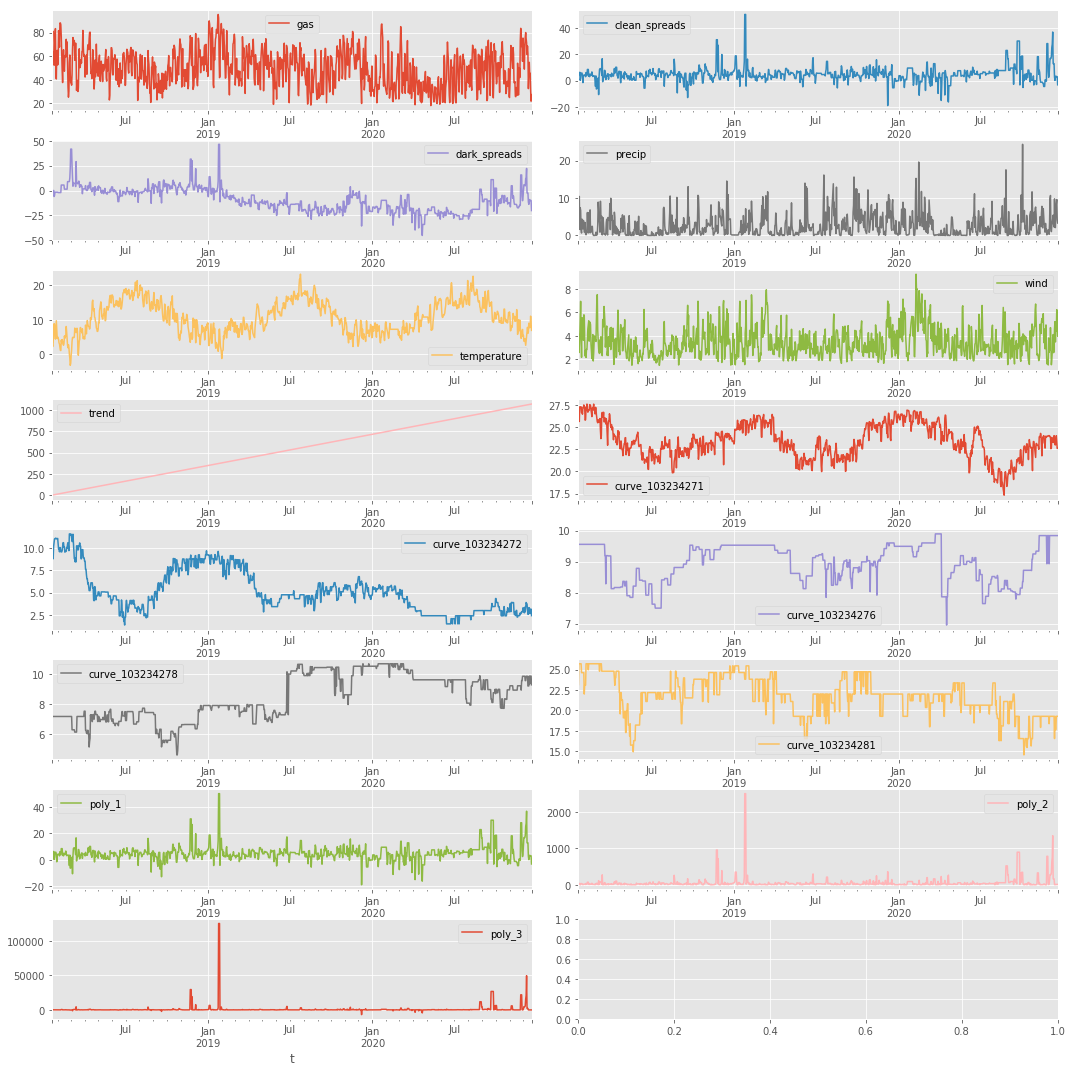

In [91]:
DM.plot(drop_names = categorical_cols + fourier_cols + days_cols )

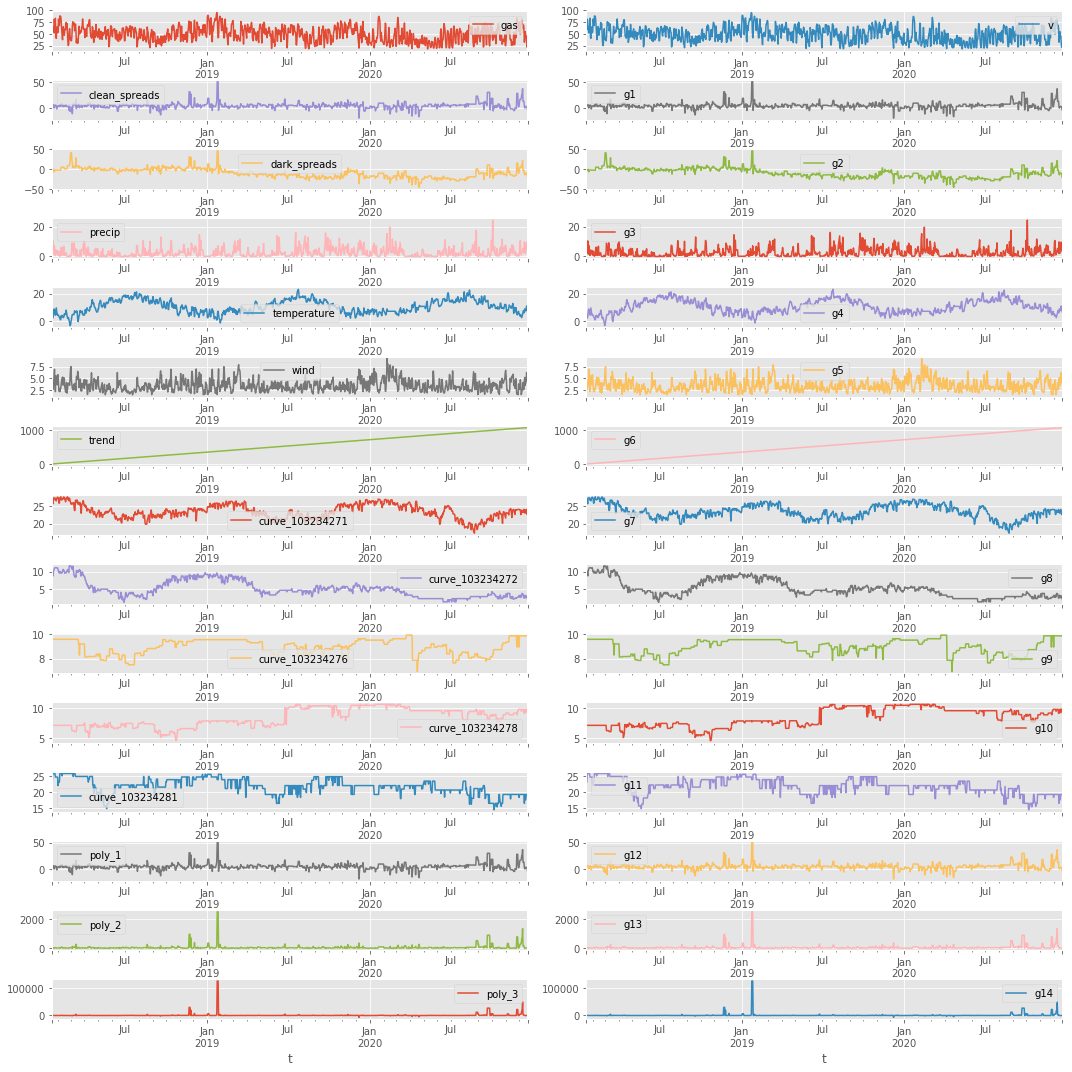

In [92]:
DM.plot(drop_names = categorical_cols + fourier_cols + days_cols, g_form=True )

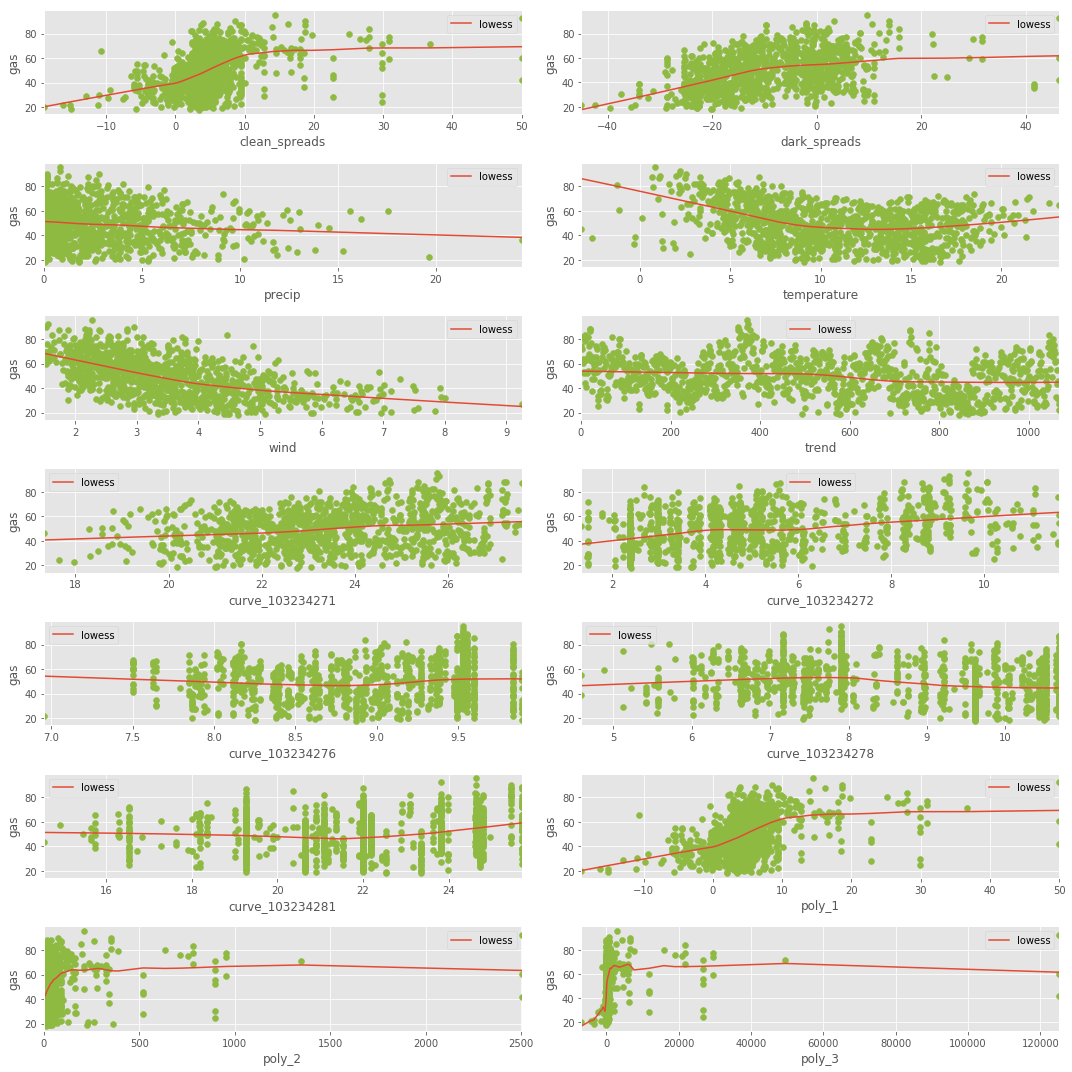

In [95]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols + days_cols)

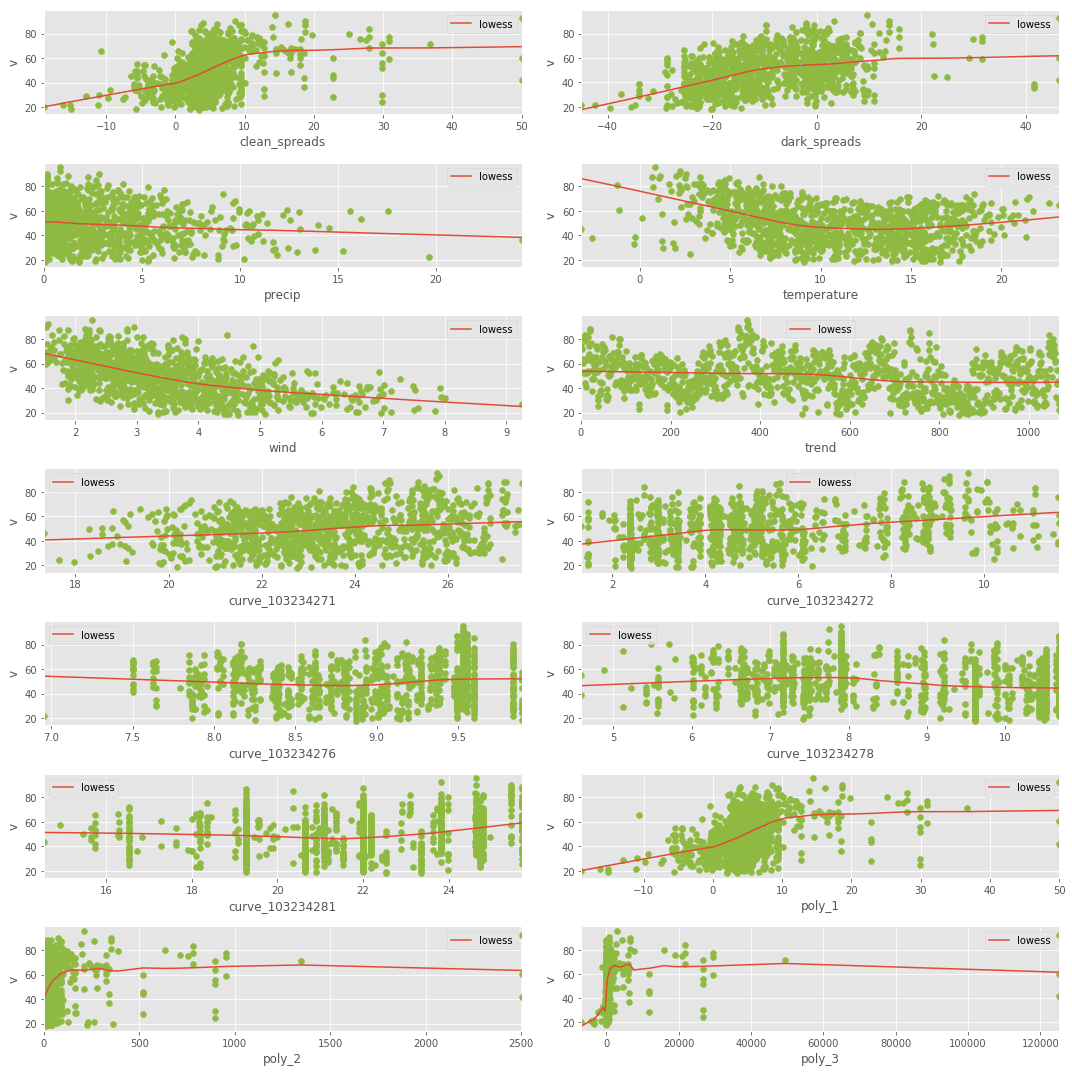

In [93]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols + days_cols, g_form=True)

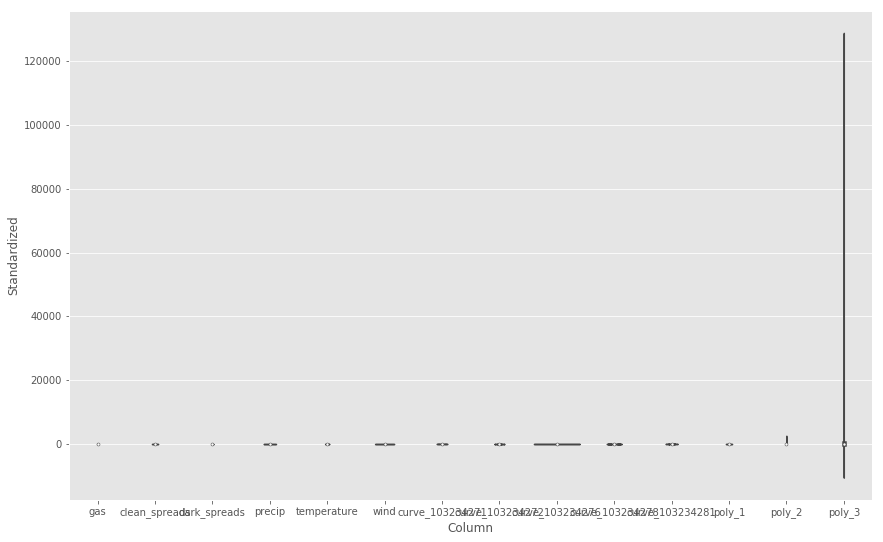

In [96]:
fig, ax = plt.subplots(figsize=figsize)
_ = DM.dm[['v']+DM.x_to_g([c for c in covariates if c!='trend'])].rename(columns=DM.names).melt(var_name='Column', value_name='Standardized')
sns.violinplot(x="Column", y="Standardized", data=_, ax=ax)
plt.show()

## Grid Search based on BIC

In [102]:
covariates

['clean_spreads',
 'dark_spreads',
 'precip',
 'temperature',
 'wind',
 'trend',
 'curve_103234271',
 'curve_103234272',
 'curve_103234276',
 'curve_103234278',
 'curve_103234281',
 'poly_1',
 'poly_2',
 'poly_3']

In [115]:
from itertools import product
from functools import partial

powerset = partial(stb.utils.common.powerset, skip_empty_set=True)
nms = [DM._inv_names.get(k) for k in covariates if k!='const' ]
results = []
grid = list(powerset(nms))
N = len(grid)
i=0
for elem in grid:
    print(f'{N-i}', end='| ')
    nm = ['const']  + list(elem) + DM.x_to_g(fourier_cols) + [DM.x_to_g(categorical_cols)] #+  DM.x_to_g(days_cols)
    try:
        gc = stb.GeneralCalibrator(sm.OLS, dict())
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(nDM.n))
        results.append([elem, gm.fitted.bic, nm])jupy
    except Exception as e:
        print(e.args[0])
        continue
    i+=1
df_res = pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']]
df_res.head(5)

specification = df_res.head(1)['config'].values.tolist()[0]; '| '.join(map(DM.names.get, specification))


16383| 16382| 16381| 16380| 16379| 16378| 16377| 16376| 16375| 16374| 16373| 16372| 16371| 16370| 16369| 16368| 16367| 16366| 16365| 16364| 16363| 16362| 16361| 16360| 16359| 16358| 16357| 16356| 16355| 16354| 16353| 16352| 16351| 16350| 16349| 16348| 16347| 16346| 16345| 16344| 16343| 16342| 16341| 16340| 16339| 16338| 16337| 16336| 16335| 16334| 16333| 16332| 16331| 16330| 16329| 16328| 16327| 16326| 16325| 16324| 16323| 16322| 16321| 16320| 16319| 16318| 16317| 16316| 16315| 16314| 16313| 16312| 16311| 16310| 16309| 16308| 16307| 16306| 16305| 16304| 16303| 16302| 16301| 16300| 16299| 16298| 16297| 16296| 16295| 16294| 16293| 16292| 16291| 16290| 16289| 16288| 16287| 16286| 16285| 16284| 16283| 16282| 16281| 16280| 16279| 16278| 16277| 16276| 16275| 16274| 16273| 16272| 16271| 16270| 16269| 16268| 16267| 16266| 16265| 16264| 16263| 16262| 16261| 16260| 16259| 16258| 16257| 16256| 16255| 16254| 16253| 16252| 16251| 16250| 16249| 16248| 16247| 16246| 16245| 16244| 16243| 16242| 16241|

| 15199| 15198| 15197| 15196| 15195| 15194| 15193| 15192| 15191| 15190| 15189| 15188| 15187| 15186| 15185| 15184| 15183| 15182| 15181| 15180| 15179| 15178| 15177| 15176| 15175| 15174| 15173| 15172| 15171| 15170| 15169| 15168| 15167| 15166| 15165| 15164| 15163| 15162| 15161| 15160| 15159| 15158| 15157| 15156| 15155| 15154| 15153| 15152| 15151| 15150| 15149| 15148| 15147| 15146| 15145| 15144| 15143| 15142| 15141| 15140| 15139| 15138| 15137| 15136| 15135| 15134| 15133| 15132| 15131| 15130| 15129| 15128| 15127| 15126| 15125| 15124| 15123| 15122| 15121| 15120| 15119| 15118| 15117| 15116| 15115| 15114| 15113| 15112| 15111| 15110| 15109| 15108| 15107| 15106| 15105| 15104| 15103| 15102| 15101| 15100| 15099| 15098| 15097| 15096| 15095| 15094| 15093| 15092| 15091| 15090| 15089| 15088| 15087| 15086| 15085| 15084| 15083| 15082| 15081| 15080| 15079| 15078| 15077| 15076| 15075| 15074| 15073| 15072| 15071| 15070| 15069| 15068| 15067| 15066| 15065| 15064| 15063| 15062| 15061| 15060| 15059| 15058| 1505

| 14021| 14020| 14019| 14018| 14017| 14016| 14015| 14014| 14013| 14012| 14011| 14010| 14009| 14008| 14007| 14006| 14005| 14004| 14003| 14002| 14001| 14000| 13999| 13998| 13997| 13996| 13995| 13994| 13993| 13992| 13991| 13990| 13989| 13988| 13987| 13986| 13985| 13984| 13983| 13982| 13981| 13980| 13979| 13978| 13977| 13976| 13975| 13974| 13973| 13972| 13971| 13970| 13969| 13968| 13967| 13966| 13965| 13964| 13963| 13962| 13961| 13960| 13959| 13958| 13957| 13956| 13955| 13954| 13953| 13952| 13951| 13950| 13949| 13948| 13947| 13946| 13945| 13944| 13943| 13942| 13941| 13940| 13939| 13938| 13937| 13936| 13935| 13934| 13933| 13932| 13931| 13930| 13929| 13928| 13927| 13926| 13925| 13924| 13923| 13922| 13921| 13920| 13919| 13918| 13917| 13916| 13915| 13914| 13913| 13912| 13911| 13910| 13909| 13908| 13907| 13906| 13905| 13904| 13903| 13902| 13901| 13900| 13899| 13898| 13897| 13896| 13895| 13894| 13893| 13892| 13891| 13890| 13889| 13888| 13887| 13886| 13885| 13884| 13883| 13882| 13881| 13880| 1387

12842| 12841| 12840| 12839| 12838| 12837| 12836| 12835| 12834| 12833| 12832| 12831| 12830| 12829| 12828| 12827| 12826| 12825| 12824| 12823| 12822| 12821| 12820| 12819| 12818| 12817| 12816| 12815| 12814| 12813| 12812| 12811| 12810| 12809| 12808| 12807| 12806| 12805| 12804| 12803| 12802| 12801| 12800| 12799| 12798| 12797| 12796| 12795| 12794| 12793| 12792| 12791| 12790| 12789| 12788| 12787| 12786| 12785| 12784| 12783| 12782| 12781| 12780| 12779| 12778| 12777| 12776| 12775| 12774| 12773| 12772| 12771| 12770| 12769| 12768| 12767| 12766| 12765| 12764| 12763| 12762| 12761| 12760| 12759| 12758| 12757| 12756| 12755| 12754| 12753| 12752| 12751| 12750| 12749| 12748| 12747| 12746| 12745| 12744| 12743| 12742| 12741| 12740| 12739| 12738| 12737| 12736| 12735| 12734| 12733| 12732| 12731| 12730| 12729| 12728| 12727| 12726| 12725| 12724| 12723| 12722| 12721| 12720| 12719| 12718| 12717| 12716| 12715| 12714| 12713| 12712| 12711| 12710| 12709| 12708| 12707| 12706| 12705| 12704| 12703| 12702| 12701| 12700|

11670| 11669| 11668| 11667| 11666| 11665| 11664| 11663| 11662| 11661| 11660| 11659| 11658| 11657| 11656| 11655| 11654| 11653| 11652| 11651| 11650| 11649| 11648| 11647| 11646| 11645| 11644| 11643| 11642| 11641| 11640| 11639| 11638| 11637| 11636| 11635| 11634| 11633| 11632| 11631| 11630| 11629| 11628| 11627| 11626| 11625| 11624| 11623| 11622| 11621| 11620| 11619| 11618| 11617| 11616| 11615| 11614| 11613| 11612| 11611| 11610| 11609| 11608| 11607| 11606| 11605| 11604| 11603| 11602| 11601| 11600| 11599| 11598| 11597| 11596| 11595| 11594| 11593| 11592| 11591| 11590| 11589| 11588| 11587| 11586| 11585| 11584| 11583| 11582| 11581| 11580| 11579| 11578| 11577| 11576| 11575| 11574| 11573| 11572| 11571| 11570| 11569| 11568| 11567| 11566| 11565| 11564| 11563| 11562| 11561| 11560| 11559| 11558| 11557| 11556| 11555| 11554| 11553| 11552| 11551| 11550| 11549| 11548| 11547| 11546| 11545| 11544| 11543| 11542| 11541| 11540| 11539| 11538| 11537| 11536| 11535| 11534| 11533| 11532| 11531| 11530| 11529| 11528|

| 10493| 10492| 10491| 10490| 10489| 10488| 10487| 10486| 10485| 10484| 10483| 10482| 10481| 10480| 10479| 10478| 10477| 10476| 10475| 10474| 10473| 10472| 10471| 10470| 10469| 10468| 10467| 10466| 10465| 10464| 10463| 10462| 10461| 10460| 10459| 10458| 10457| 10456| 10455| 10454| 10453| 10452| 10451| 10450| 10449| 10448| 10447| 10446| 10445| 10444| 10443| 10442| 10441| 10440| 10439| 10438| 10437| 10436| 10435| 10434| 10433| 10432| 10431| 10430| 10429| 10428| 10427| 10426| 10425| 10424| 10423| 10422| 10421| 10420| 10419| 10418| 10417| 10416| 10415| 10414| 10413| 10412| 10411| 10410| 10409| 10408| 10407| 10406| 10405| 10404| 10403| 10402| 10401| 10400| 10399| 10398| 10397| 10396| 10395| 10394| 10393| 10392| 10391| 10390| 10389| 10388| 10387| 10386| 10385| 10384| 10383| 10382| 10381| 10380| 10379| 10378| 10377| 10376| 10375| 10374| 10373| 10372| 10371| 10370| 10369| 10368| 10367| 10366| 10365| 10364| 10363| 10362| 10361| 10360| 10359| 10358| 10357| 10356| 10355| 10354| 10353| 10352| 1035

9209| 9208| 9207| 9206| 9205| 9204| 9203| 9202| 9201| 9200| 9199| 9198| 9197| 9196| 9195| 9194| 9193| 9192| 9191| 9190| 9189| 9188| 9187| 9186| 9185| 9184| 9183| 9182| 9181| 9180| 9179| 9178| 9177| 9176| 9175| 9174| 9173| 9172| 9171| 9170| 9169| 9168| 9167| 9166| 9165| 9164| 9163| 9162| 9161| 9160| 9159| 9158| 9157| 9156| 9155| 9154| 9153| 9152| 9151| 9150| 9149| 9148| 9147| 9146| 9145| 9144| 9143| 9142| 9141| 9140| 9139| 9138| 9137| 9136| 9135| 9134| 9133| 9132| 9131| 9130| 9129| 9128| 9127| 9126| 9125| 9124| 9123| 9122| 9121| 9120| 9119| 9118| 9117| 9116| 9115| 9114| 9113| 9112| 9111| 9110| 9109| 9108| 9107| 9106| 9105| 9104| 9103| 9102| 9101| 9100| 9099| 9098| 9097| 9096| 9095| 9094| 9093| 9092| 9091| 9090| 9089| 9088| 9087| 9086| 9085| 9084| 9083| 9082| 9081| 9080| 9079| 9078| 9077| 9076| 9075| 9074| 9073| 9072| 9071| 9070| 9069| 9068| 9067| 9066| 9065| 9064| 9063| 9062| 9061| 9060| 9059| 9058| 9057| 9056| 9055| 9054| 9053| 9052| 9051| 9050| 9049| 9048| 9047| 9046| 9045| 9044| 9043

7840| 7839| 7838| 7837| 7836| 7835| 7834| 7833| 7832| 7831| 7830| 7829| 7828| 7827| 7826| 7825| 7824| 7823| 7822| 7821| 7820| 7819| 7818| 7817| 7816| 7815| 7814| 7813| 7812| 7811| 7810| 7809| 7808| 7807| 7806| 7805| 7804| 7803| 7802| 7801| 7800| 7799| 7798| 7797| 7796| 7795| 7794| 7793| 7792| 7791| 7790| 7789| 7788| 7787| 7786| 7785| 7784| 7783| 7782| 7781| 7780| 7779| 7778| 7777| 7776| 7775| 7774| 7773| 7772| 7771| 7770| 7769| 7768| 7767| 7766| 7765| 7764| 7763| 7762| 7761| 7760| 7759| 7758| 7757| 7756| 7755| 7754| 7753| 7752| 7751| 7750| 7749| 7748| 7747| 7746| 7745| 7744| 7743| 7742| 7741| 7740| 7739| 7738| 7737| 7736| 7735| 7734| 7733| 7732| 7731| 7730| 7729| 7728| 7727| 7726| 7725| 7724| 7723| 7722| 7721| 7720| 7719| 7718| 7717| 7716| 7715| 7714| 7713| 7712| 7711| 7710| 7709| 7708| 7707| 7706| 7705| 7704| 7703| 7702| 7701| 7700| 7699| 7698| 7697| 7696| 7695| 7694| 7693| 7692| 7691| 7690| 7689| 7688| 7687| 7686| 7685| 7684| 7683| 7682| 7681| 7680| 7679| 7678| 7677| 7676| 7675| 7674

| 6472| 6471| 6470| 6469| 6468| 6467| 6466| 6465| 6464| 6463| 6462| 6461| 6460| 6459| 6458| 6457| 6456| 6455| 6454| 6453| 6452| 6451| 6450| 6449| 6448| 6447| 6446| 6445| 6444| 6443| 6442| 6441| 6440| 6439| 6438| 6437| 6436| 6435| 6434| 6433| 6432| 6431| 6430| 6429| 6428| 6427| 6426| 6425| 6424| 6423| 6422| 6421| 6420| 6419| 6418| 6417| 6416| 6415| 6414| 6413| 6412| 6411| 6410| 6409| 6408| 6407| 6406| 6405| 6404| 6403| 6402| 6401| 6400| 6399| 6398| 6397| 6396| 6395| 6394| 6393| 6392| 6391| 6390| 6389| 6388| 6387| 6386| 6385| 6384| 6383| 6382| 6381| 6380| 6379| 6378| 6377| 6376| 6375| 6374| 6373| 6372| 6371| 6370| 6369| 6368| 6367| 6366| 6365| 6364| 6363| 6362| 6361| 6360| 6359| 6358| 6357| 6356| 6355| 6354| 6353| 6352| 6351| 6350| 6349| 6348| 6347| 6346| 6345| 6344| 6343| 6342| 6341| 6340| 6339| 6338| 6337| 6336| 6335| 6334| 6333| 6332| 6331| 6330| 6329| 6328| 6327| 6326| 6325| 6324| 6323| 6322| 6321| 6320| 6319| 6318| 6317| 6316| 6315| 6314| 6313| 6312| 6311| 6310| 6309| 6308| 6307| 63

| 5099| 5098| 5097| 5096| 5095| 5094| 5093| 5092| 5091| 5090| 5089| 5088| 5087| 5086| 5085| 5084| 5083| 5082| 5081| 5080| 5079| 5078| 5077| 5076| 5075| 5074| 5073| 5072| 5071| 5070| 5069| 5068| 5067| 5066| 5065| 5064| 5063| 5062| 5061| 5060| 5059| 5058| 5057| 5056| 5055| 5054| 5053| 5052| 5051| 5050| 5049| 5048| 5047| 5046| 5045| 5044| 5043| 5042| 5041| 5040| 5039| 5038| 5037| 5036| 5035| 5034| 5033| 5032| 5031| 5030| 5029| 5028| 5027| 5026| 5025| 5024| 5023| 5022| 5021| 5020| 5019| 5018| 5017| 5016| 5015| 5014| 5013| 5012| 5011| 5010| 5009| 5008| 5007| 5006| 5005| 5004| 5003| 5002| 5001| 5000| 4999| 4998| 4997| 4996| 4995| 4994| 4993| 4992| 4991| 4990| 4989| 4988| 4987| 4986| 4985| 4984| 4983| 4982| 4981| 4980| 4979| 4978| 4977| 4976| 4975| 4974| 4973| 4972| 4971| 4970| 4969| 4968| 4967| 4966| 4965| 4964| 4963| 4962| 4961| 4960| 4959| 4958| 4957| 4956| 4955| 4954| 4953| 4952| 4951| 4950| 4949| 4948| 4947| 4946| 4945| 4944| 4943| 4942| 4941| 4940| 4939| 4938| 4937| 4936| 4935| 4934| 49

3727| 3726| 3725| 3724| 3723| 3722| 3721| 3720| 3719| 3718| 3717| 3716| 3715| 3714| 3713| 3712| 3711| 3710| 3709| 3708| 3707| 3706| 3705| 3704| 3703| 3702| 3701| 3700| 3699| 3698| 3697| 3696| 3695| 3694| 3693| 3692| 3691| 3690| 3689| 3688| 3687| 3686| 3685| 3684| 3683| 3682| 3681| 3680| 3679| 3678| 3677| 3676| 3675| 3674| 3673| 3672| 3671| 3670| 3669| 3668| 3667| 3666| 3665| 3664| 3663| 3662| 3661| 3660| 3659| 3658| 3657| 3656| 3655| 3654| 3653| 3652| 3651| 3650| 3649| 3648| 3647| 3646| 3645| 3644| 3643| 3642| 3641| 3640| 3639| 3638| 3637| 3636| 3635| 3634| 3633| 3632| 3631| 3630| 3629| 3628| 3627| 3626| 3625| 3624| 3623| 3622| 3621| 3620| 3619| 3618| 3617| 3616| 3615| 3614| 3613| 3612| 3611| 3610| 3609| 3608| 3607| 3606| 3605| 3604| 3603| 3602| 3601| 3600| 3599| 3598| 3597| 3596| 3595| 3594| 3593| 3592| 3591| 3590| 3589| 3588| 3587| 3586| 3585| 3584| 3583| 3582| 3581| 3580| 3579| 3578| 3577| 3576| 3575| 3574| 3573| 3572| 3571| 3570| 3569| 3568| 3567| 3566| 3565| 3564| 3563| 3562| 3561

2356| 2355| 2354| 2353| 2352| 2351| 2350| 2349| 2348| 2347| 2346| 2345| 2344| 2343| 2342| 2341| 2340| 2339| 2338| 2337| 2336| 2335| 2334| 2333| 2332| 2331| 2330| 2329| 2328| 2327| 2326| 2325| 2324| 2323| 2322| 2321| 2320| 2319| 2318| 2317| 2316| 2315| 2314| 2313| 2312| 2311| 2310| 2309| 2308| 2307| 2306| 2305| 2304| 2303| 2302| 2301| 2300| 2299| 2298| 2297| 2296| 2295| 2294| 2293| 2292| 2291| 2290| 2289| 2288| 2287| 2286| 2285| 2284| 2283| 2282| 2281| 2280| 2279| 2278| 2277| 2276| 2275| 2274| 2273| 2272| 2271| 2270| 2269| 2268| 2267| 2266| 2265| 2264| 2263| 2262| 2261| 2260| 2259| 2258| 2257| 2256| 2255| 2254| 2253| 2252| 2251| 2250| 2249| 2248| 2247| 2246| 2245| 2244| 2243| 2242| 2241| 2240| 2239| 2238| 2237| 2236| 2235| 2234| 2233| 2232| 2231| 2230| 2229| 2228| 2227| 2226| 2225| 2224| 2223| 2222| 2221| 2220| 2219| 2218| 2217| 2216| 2215| 2214| 2213| 2212| 2211| 2210| 2209| 2208| 2207| 2206| 2205| 2204| 2203| 2202| 2201| 2200| 2199| 2198| 2197| 2196| 2195| 2194| 2193| 2192| 2191| 2190

983| 982| 981| 980| 979| 978| 977| 976| 975| 974| 973| 972| 971| 970| 969| 968| 967| 966| 965| 964| 963| 962| 961| 960| 959| 958| 957| 956| 955| 954| 953| 952| 951| 950| 949| 948| 947| 946| 945| 944| 943| 942| 941| 940| 939| 938| 937| 936| 935| 934| 933| 932| 931| 930| 929| 928| 927| 926| 925| 924| 923| 922| 921| 920| 919| 918| 917| 916| 915| 914| 913| 912| 911| 910| 909| 908| 907| 906| 905| 904| 903| 902| 901| 900| 899| 898| 897| 896| 895| 894| 893| 892| 891| 890| 889| 888| 887| 886| 885| 884| 883| 882| 881| 880| 879| 878| 877| 876| 875| 874| 873| 872| 871| 870| 869| 868| 867| 866| 865| 864| 863| 862| 861| 860| 859| 858| 857| 856| 855| 854| 853| 852| 851| 850| 849| 848| 847| 846| 845| 844| 843| 842| 841| 840| 839| 838| 837| 836| 835| 834| 833| 832| 831| 830| 829| 828| 827| 826| 825| 824| 823| 822| 821| 820| 819| 818| 817| 816| 815| 814| 813| 812| 811| 810| 809| 808| 807| 806| 805| 804| 803| 802| 801| 800| 799| 798| 797| 796| 795| 794| 793| 792| 791| 790| 789| 788| 787| 786| 785| 784| 

'const| clean_spreads| precip| temperature| wind| curve_103234271| curve_103234272| curve_103234281| poly_1| poly_3| S1-7| C1-7| S2-7| C2-7| S3-7| C3-7| mo_th_yes'

In [116]:
specification = DM.g_to_x(specification)

In [117]:
DM.g_to_x(specification)

['const',
 'clean_spreads',
 'precip',
 'temperature',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'curve_103234281',
 'poly_1',
 'poly_3',
 'S1-7',
 'C1-7',
 'S2-7',
 'C2-7',
 'S3-7',
 'C3-7',
 'mo_th_yes']

# Cross-validation

In [118]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6, test_size=FORECAST_HORIZON)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [119]:
metric = stb.metrics.root_mean_squared_error

## Grid Search based on Cross Validation Error

In [120]:
gc = stb.GeneralCalibrator(sm.RLM, dict())
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 8.34, CV_std: 0.98 | (7.37  9.32)
CV_error/range: 10.78% | (range: 77)


In [121]:
gc = stb.GeneralCalibrator(sm.WLS, dict())
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 8.51, CV_std: 0.97 | (7.55  9.48)
CV_error/range: 11.00% | (range: 77)


In [122]:
gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 8.51, CV_std: 0.97 | (7.55  9.48)
CV_error/range: 11.00% | (range: 77)


## In sample

In [123]:
specification

['const',
 'clean_spreads',
 'precip',
 'temperature',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'curve_103234281',
 'poly_1',
 'poly_3',
 'S1-7',
 'C1-7',
 'S2-7',
 'C2-7',
 'S3-7',
 'C3-7',
 'mo_th_yes']

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     168.4
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          6.87e-257
Time:                        12:40:41   Log-Likelihood:                -3827.8
No. Observations:                1068   AIC:                             7686.
Df Residuals:                    1053   BIC:                             7760.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.9280      4.863     10.062      0.0

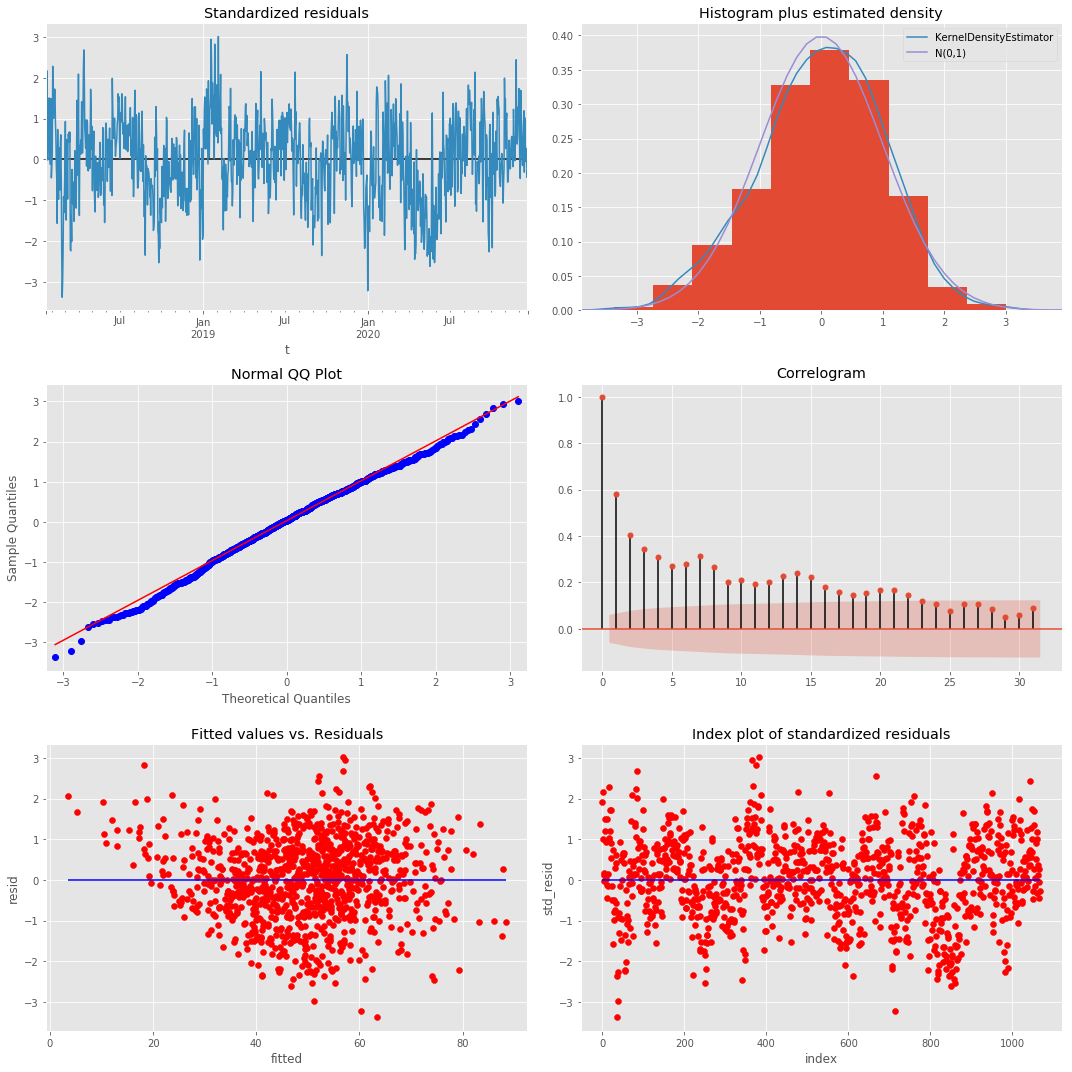

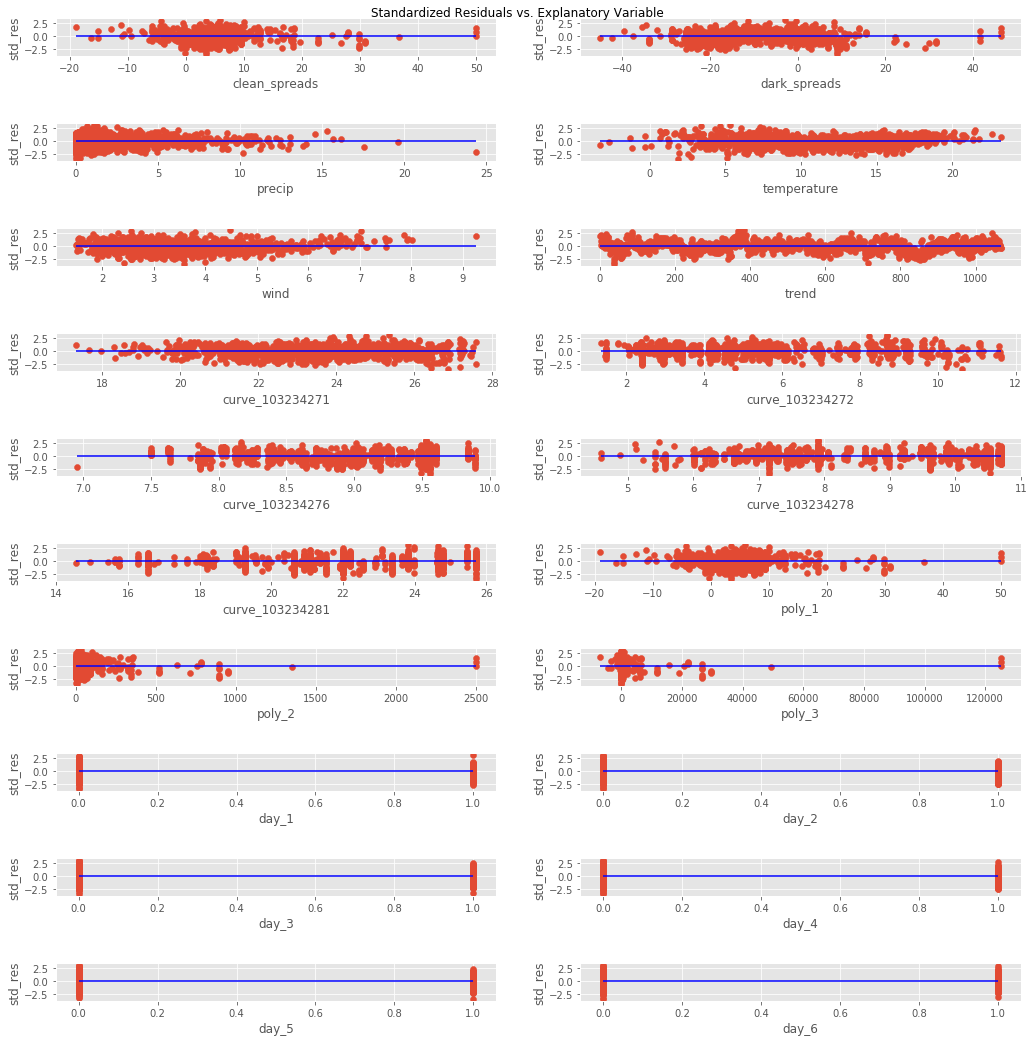

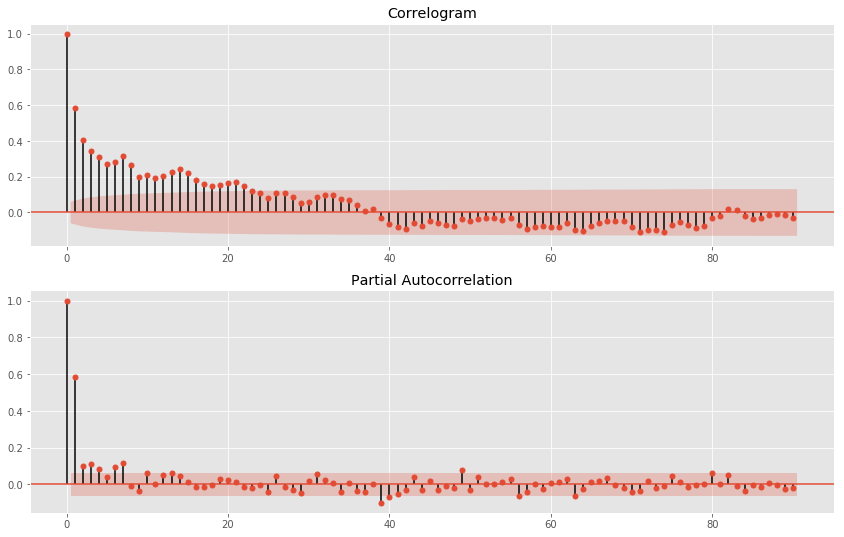

In [124]:
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(DM.n))
gm.forecast(range(DM.n))
print(gm.fitted.summary())
gm.plot_diagnostics(drop_names=categorical_cols+fourier_cols)
stb.stat_plots.plot_acf_pcf(gm.std_residuals, kwargs_acf={'lags': 90}, kwargs_pacf={'lags':90})

NOBS = gm.fitted.nobs

Error: 8.71559519


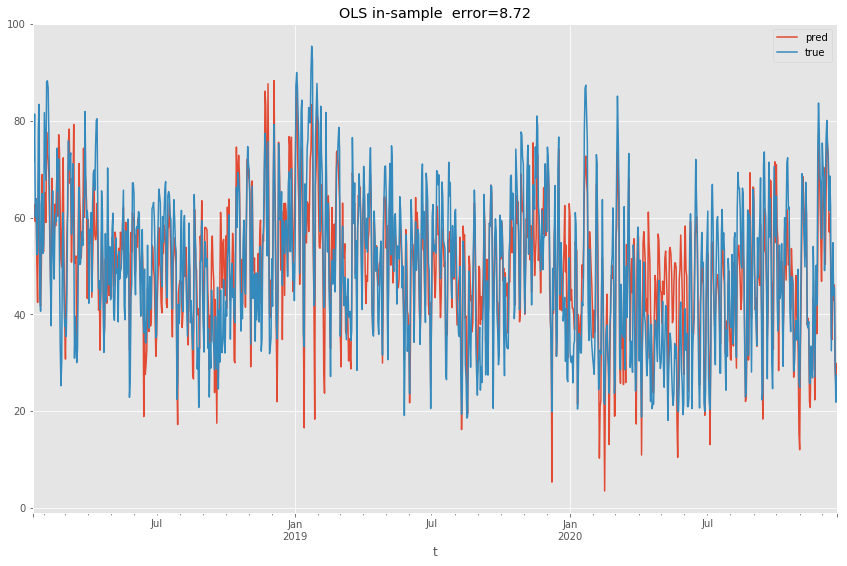

In [125]:
exog = DM.gX[DM.x_to_g(specification)]
v_hat = gm.fitted.predict(exog=exog)
y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
in_sample_error = metric(DM.y.loc[y_hat.index], y_hat)
print(f'Error: {in_sample_error:.8f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
DM.y.loc[y_hat.index].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'OLS in-sample  error={in_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [126]:
 DM.gX[DM.x_to_g(specification)].tail()

const        g1        g3         g4    g5         g7        g8  \
t                                                                             
2020-12-16    1.0  3.338657  7.320000   7.672727  4.91  23.254545  2.672727   
2020-12-17    1.0  2.933020  8.473333   8.186364  4.39  24.019091  2.672727   
2020-12-18    1.0  2.933020  9.626667  11.031818  6.23  23.260909  3.131818   
2020-12-19    1.0  2.933020  4.280000   8.913636  5.29  22.579091  3.131818   
2020-12-20    1.0 -3.251601  3.320000   6.895455  3.97  22.615454  2.400000   

                  g11       g12        g14           g16       g17  \
t                                                                    
2020-12-16  17.636363  3.338657  37.214770  1.961416e-14  1.000000   
2020-12-17  19.272727  2.933020  25.231616  7.818315e-01  0.623490   
2020-12-18  19.272727  2.933020  25.231616  9.749279e-01 -0.222521   
2020-12-19  19.272727  2.933020  25.231616  4.338837e-01 -0.900969   
2020-12-20  19.272727 -3.251601 -34.378892 -4.338837e-01 -0.900969   

                     g18       g19           g20       g21  g15  
t                                                                
2020-12-16  3.922831e-14  1.000000 -2.822180e-13  1.000000    1  
2020-12-17  9.749279e-01 -0.222521  4.338837e-01 -0.900969    1  
2020-12-18 -4.338837e-01 -0.900969 -7.818315e-01  0.623490    0  
2020-12-19 -7.818315e-01  0.623490  9.749279e-01 -0.222521    0  
2020-12-20  7.818315e-01  0.623490 -9.749279e-01 -0.222521    0

## Out of sample

In [128]:
data = myData.load_design_matrix()

outDataDM = deepcopy(data[(data.index>=t_out_sample) & (data.index<t_out_time)]);

outY = outDataDM[dependent_var]

#adding trend explicitely
outDataDM['trend'] = range(1, len(outDataDM.index)+1)

# monday_thursday vs. the rest
outDataDM['weekday'] = outDataDM.index.weekday
outDataDM['weekday'] = outDataDM['weekday'].apply(lambda t: t+1)
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['weekday'], prefix='day'))
outDataDM['monday_thursday'] = outDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outDataDM = outDataDM.join(get_fourier_series(outDataDM.index, K))
covariates + categorical_cols + fourier_cols + days_cols


# let's add polynomials for clean spreads
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(outDataDM['clean_spreads'].values.reshape(-1,1))
xp = pd.DataFrame(xp, index=outDataDM.index).iloc[:, 1:]
xp.columns = [f'poly_{c}' for c in xp.columns]
outDataDM = pd.concat([outDataDM, xp], axis=1)


outX = outDataDM[covariates + categorical_cols  + fourier_cols + days_cols]; #outX.head(2)

outDM = stb.DesignMatrix(y=outY, X=outX, f=DM.f, gs=DM.gs, add_const=True)

exog = outDM.gX[outDM.x_to_g(specification)]

2021-04-27 12:41:48,207: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 75: INFO: Retrieving....


In [144]:
specification

['const',
 'clean_spreads',
 'precip',
 'temperature',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'curve_103234281',
 'poly_1',
 'poly_3',
 'S1-7',
 'C1-7',
 'S2-7',
 'C2-7',
 'S3-7',
 'C3-7',
 'mo_th_yes']

In [143]:
exog.rename(columns=outDM.names).columns

Index(['const', 'clean_spreads', 'precip', 'temperature', 'wind',
       'curve_103234271', 'curve_103234272', 'curve_103234281', 'poly_1',
       'poly_3', 'S1-7', 'C1-7', 'S2-7', 'C2-7', 'S3-7', 'C3-7', 'mo_th_yes'],
      dtype='object')

In [154]:
gm.fitted.params

const              55.768143
clean_spreads       0.254425
precip              0.466014
temperature        -0.609767
wind               -7.390035
curve_103234271     0.292658
curve_103234272     1.882418
curve_103234281    -0.383496
poly_1              0.254425
poly_3             -0.000030
S1-7                5.480942
C1-7               -7.536394
S2-7               -2.705670
C2-7               -0.588635
S3-7               -4.903921
C3-7                1.879395
mo_th_yes          24.513131
dtype: float64

Error: 15.72452488


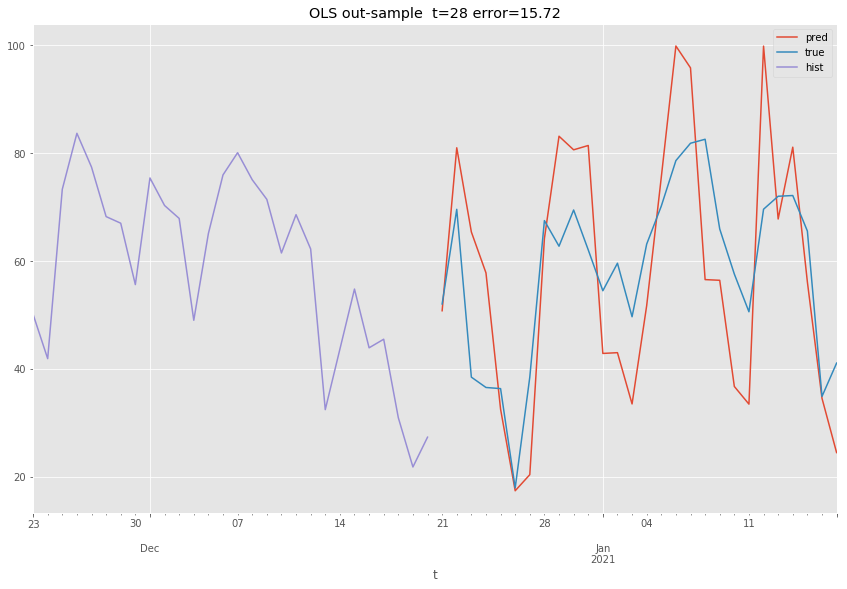

In [158]:
v_hat = exog.rename(columns=outDM.names).dot(gm.fitted.params)

y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
out_of_sample_error = metric(outDM.y.loc[y_hat.index], y_hat)
print(f'Error: {out_of_sample_error:.8f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
outDM.y.loc[y_hat.index].plot(ax=ax)
DM.dm.y[-FORECAST_HORIZON:].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'OLS out-sample  t={FORECAST_HORIZON} error={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Out of time

In [130]:
data = myData.load_design_matrix()

outTimeDataDM = deepcopy(data[int(-NOBS-FORECAST_HORIZON):])

outTimeY = outTimeDataDM[dependent_var]

#adding trend explicitely
outTimeDataDM['trend'] = range(1, len(outTimeDataDM.index)+1)

# monday_thursday vs. the rest
outTimeDataDM['weekday'] = outTimeDataDM.index.weekday
outTimeDataDM['weekday'] = outTimeDataDM['weekday'].apply(lambda t: t+1)
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['weekday'], prefix='day'))
outTimeDataDM['monday_thursday'] = outTimeDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outTimeDataDM = outTimeDataDM.join(get_fourier_series(outTimeDataDM.index, K))

# let's add polynomials for clean spreads
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(outTimeDataDM['clean_spreads'].values.reshape(-1,1))
xp = pd.DataFrame(xp, index=outTimeDataDM.index).iloc[:, 1:]
xp.columns = [f'poly_{c}' for c in xp.columns]
outTimeDataDM = pd.concat([outTimeDataDM, xp], axis=1)



ddff(outTimeDataDM.head())

outX = outTimeDataDM[covariates + categorical_cols + days_cols + fourier_cols]; outX.head(2)

outTimeDM = stb.DesignMatrix(y=outTimeY, X=outX, f=f, gs=gs, add_const=True)

# ddff(outTimeDM.dm.head(2))

2021-04-27 12:42:46,836: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 75: INFO: Retrieving....


clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2018-02-15       4.046223        27.445454        10.138182         9.554545   
2018-02-16       4.046223        26.898182         9.562727         9.554545   
2018-02-17       4.046223        26.601818         9.610000         9.554545   
2018-02-18       6.529748        26.170000         9.650909         9.554545   
2018-02-19       4.375822        27.154545         9.650909         9.554545   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2018-02-15         7.163636        25.709091       1.41325  47.294989   
2018-02-16         7.163636        25.709091       1.41325  58.501659   
2018-02-17         7.163636        25.709091       1.41325  60.792909   
2018-02-18         7.163636        25.709091       1.41325  59.184069   
2018-02-19         7.163636        25.709091       1.41325  74.377294   

              precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                            
2018-02-15  0.733333     5.245455  4.94      1        4      0      0      0   
2018-02-16  1.000000     4.609091  3.27      2        5      0      0      0   
2018-02-17  1.226667     5.359091  2.70      3        6      0      0      0   
2018-02-18  2.426667     5.154545  2.07      4        7      0      0      0   
2018-02-19  2.440000     8.036364  2.48      5        1      1      0      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2018-02-15      1      0      0      0             yes         0          1   
2018-02-16      0      1      0      0              no         1          0   
2018-02-17      0      0      1      0              no         1          0   
2018-02-18      0      0      0      1              no         1          0   
2018-02-19      0      0      0      0             yes         0          1   

                S1-7      C1-7      S2-7      C2-7      S3-7      C3-7  \
day                                                                      
2018-02-15  0.781831  0.623490  0.974928 -0.222521  0.433884 -0.900969   
2018-02-16  0.974928 -0.222521 -0.433884 -0.900969 -0.781831  0.623490   
2018-02-17  0.433884 -0.900969 -0.781831  0.623490  0.974928 -0.222521   
2018-02-18 -0.433884 -0.900969  0.781831  0.623490 -0.974928 -0.222521   
2018-02-19 -0.974928 -0.222521  0.433884 -0.900969  0.781831  0.623490   

              poly_1     poly_2      poly_3  
day                                          
2018-02-15  4.046223  16.371919   66.244432  
2018-02-16  4.046223  16.371919   66.244432  
2018-02-17  4.046223  16.371919   66.244432  
2018-02-18  6.529748  42.637603  278.412782  
2018-02-19  4.375822  19.147821   83.787460

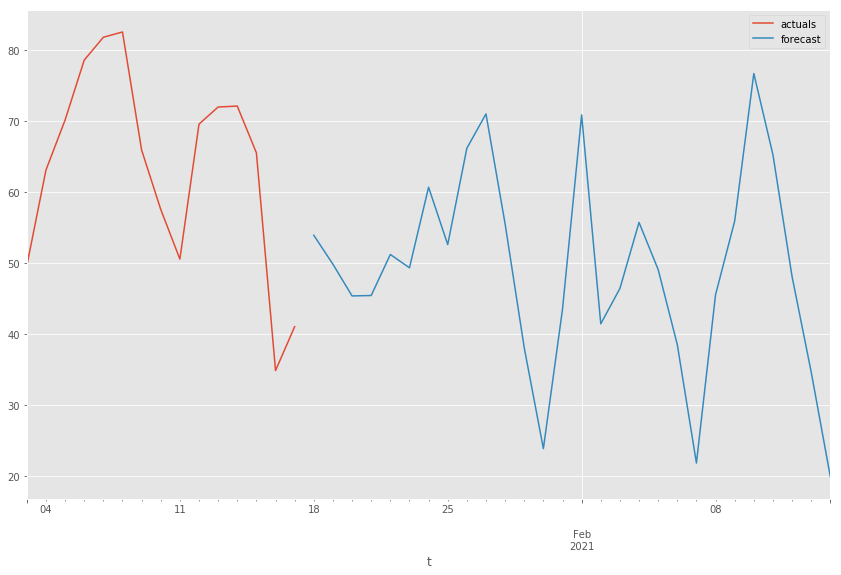

In [131]:
nDM = deepcopy(outTimeDM)
nDM.gX = nDM.gX[outTimeDM.x_to_g(specification)].rename(columns=outTimeDM.names)
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(outTimeDM.n-FORECAST_HORIZON))

gm.forecast(range(outTimeDM.n-FORECAST_HORIZON, outTimeDM.n))

v_hat = gm.v_hat
y_hat = gm.y_hat

fig, ax = plt.subplots(figsize=figsize)
data.gas.iloc[:-(FORECAST_HORIZON)].iloc[-15:].plot(ax=ax)
y_hat.plot(ax=ax)
ax.legend(['actuals', 'forecast'])
plt.show()

In [132]:
print(gm.fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     160.3
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          2.95e-249
Time:                        12:42:53   Log-Likelihood:                -3838.2
No. Observations:                1068   AIC:                             7706.
Df Residuals:                    1053   BIC:                             7781.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              55.7681      4.875     

## Benchmark from PointValue

# Summary

In [133]:
path = r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\results'
cfn = stb.utils.file.create_file_name

summary_dict = dict(zip(['YEARS',
'FORECAST_HORIZON',
'cv_m',
'cv_std',
'in_sample_error',
'out_of_sample_error'],
[YEARS,
FORECAST_HORIZON,
round(cv_m,2),
round(cv_std,4),
round(in_sample_error, 4),
round(out_of_sample_error,4)]))
summary_dict.update(dict(zip(specification, DM.g_to_x(specification))))
summary_dict.update(dict(cf=gc.cf.__name__))
transforms_dict = {k:v.__str__().split('transforms.')[1].split(' ')[0] for k,v in gs.items()}
summary_dict.update(dict(gs=transforms_dict))
summary_dict
pd.DataFrame.from_dict(summary_dict, orient='index').T.to_json(cfn(folder=path, extension='json', silent=False))

Saved to C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\results\results_2021_04_27_12_42_58.json


In [135]:
mySmartData = stb.SmartData()
mySmartData.acquire.from_folder(path)

mask = ['FORECAST_HORIZON', 'YEARS', 'cf', 'cv_m', 'cv_std', 'in_sample_error', 'out_of_sample_error' ]
pd.concat([mySmartData.get(name) for name in mySmartData.sourced.names]).reset_index(drop=True).sort_index(ascending=False)[mask].head(30)

FORECAST_HORIZON  YEARS       cf   cv_m  cv_std  in_sample_error  \
140                28      3      OLS   8.51  0.9677           8.7156   
139                90      3  SARIMAX  10.41  2.5929           7.0293   
138                90      3  SARIMAX  10.41  2.5929           7.0293   
137                28      3  SARIMAX   8.58  1.7547           7.0198   
136                14      3  SARIMAX   8.71   2.856           7.0322   
135                90      3  SARIMAX   10.2  2.3352           6.9262   
134                28      3  SARIMAX   9.54  2.2951           6.9185   
133                14      3  SARIMAX   8.79  3.2633           6.9485   
132                90      3  SARIMAX  10.37  2.4105           7.0443   
131                28      3  SARIMAX   8.44  1.7125           7.0256   
130                14      3  SARIMAX   8.54  2.7348           7.0337   
129                90      3  SARIMAX  10.41  2.5929           7.0293   
128                28      3  SARIMAX   8.58  1.7547           7.0198   
127                14      3  SARIMAX   8.71   2.856           7.0322   
126                14      3  SARIMAX   8.54  2.7348           7.0337   
125                14      3  SARIMAX   8.71   2.856           7.0322   
124                14      3  SARIMAX   8.79  3.2633           6.9485   
123                14      3  SARIMAX   8.54  2.7348           7.0337   
122                90      3  SARIMAX  10.37  2.4105           7.0443   
121                90      3  SARIMAX  10.37  2.4105           7.0443   
120                90      3  SARIMAX  10.41  2.5929           7.0293   
119                90      3  SARIMAX  10.37  2.4105           7.0443   
118                90      3  SARIMAX   10.2  2.3352           6.9262   
117                28      3      OLS   8.98  1.2358           9.0197   
116                28      3      OLS   8.98  1.2358           9.0197   
115                28      3      OLS   8.98  1.2358           9.0197   
114                28      3      OLS   8.98  1.2358           9.0197   
113                90      3  SARIMAX  10.37  2.4105           7.0443   
112                28      3      OLS   9.43  2.0782           9.1114   
111                28      3      OLS   9.43  2.0782           9.1114   

     out_of_sample_error  
140             180.8686  
139               7.5500  
138               7.5500  
137              10.0600  
136               9.5000  
135               8.7400  
134              10.5300  
133              10.4900  
132               7.2700  
131               9.6300  
130               9.8900  
129               7.5500  
128              10.0600  
127               9.5000  
126               9.8900  
125               9.5000  
124              10.4900  
123               9.8900  
122               7.2700  
121               7.2700  
120               7.5500  
119               7.2700  
118               8.7400  
117              24.2659  
116              50.1503  
115              50.1503  
114              50.1503  
113               7.2700  
112              16.6281  
111              16.6281